In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [7]:
%matplotlib inline

# utilities
import time
import os

import subprocess
import itertools

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# network analysis tools
import igraph as ig

# multiprocessing tools
import multiprocessing as mp


# visualization tools
import matplotlib.pyplot as plt

from lib import networks
from lib import qtls

%autosave 15

Autosaving every 15 seconds


Take a look at readme.md in /data folder for data description. (currently unavailable)

In [11]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/genotypes/processed_genotypes.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/processed_genotypes.csv")
eQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/processed_genotypes.csv")
pQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)

# pandas DataFrame —> numpy matrix = 2x speedup
pQTLs_expression_mx = \
    pQTLs_expression_df.as_matrix(
        columns=pQTLs_expression_df.columns[1:]
    )
pQTLs_genotypes_mx = \
    pQTLs_genotypes_df.as_matrix(
        columns=pQTLs_genotypes_df.columns[1:]
    )

# QTLs estimated with MatrixEQTL package for R
eQTLs_df = pd.read_table("./data/eQTLs/results.csv")
# eQTLs_df = eQTLs_df[eQTLs_df["q.value"] <= 0.05]
pQTLs_df = pd.read_table("./data/pQTLs/results.csv")
# pQTLs_df = pQTLs_df[pQTLs_df["q.value"] <= 0.05]

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]
interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

# Genetic nomenclature and mappings between different naming conventions (official lookup table)
gene_nomenclature_df = pd.read_table("./data/nomenclature/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)
std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}

# Functional modules found in PPI graph
functional_modules_df = pd.read_table("./data/interactions/bioprocess_annotations_costanzo2009.csv")
functional_modules_types = np.unique(sum([s.split(';') for s in functional_modules_df["Function"].values], []))

Index(['Interactor (sys)', 'Interactor (std)', 'Function'], dtype='object')


The plot below compares distributions of eQTLs and pQTLs in the yeast genome. Many hotspots are common, but effect sizes differ.

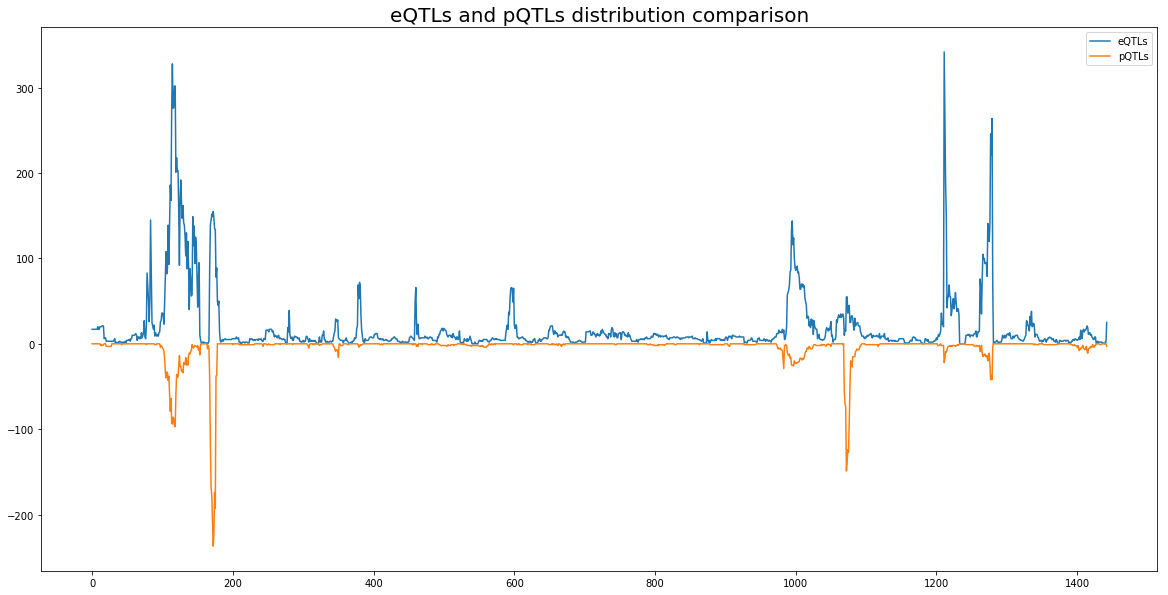

In [68]:
eQTL_y = np.array(qtls.map_linkages_to_genome_location(eQTLs_df, full_genotypes_df)[1])
pQTL_y = np.array(qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)[1])

plt.figure(figsize=(20, 10))
plt.plot(eQTL_y, label="eQTLs")
plt.plot(-pQTL_y, label="pQTLs")
plt.legend()
plt.title("eQTLs and pQTLs distribution comparison", fontsize=20)
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")

It seems rational to suppose that transcription and translation levels must be controlled by the same genetic mechanisms.  
Unfortunately, life's not that easy: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes.  
Hypothesis arises: maybe not single genes, but functional modules tend to share linkages. Goal of this work is to test that hypothesis given yeast interactome data.

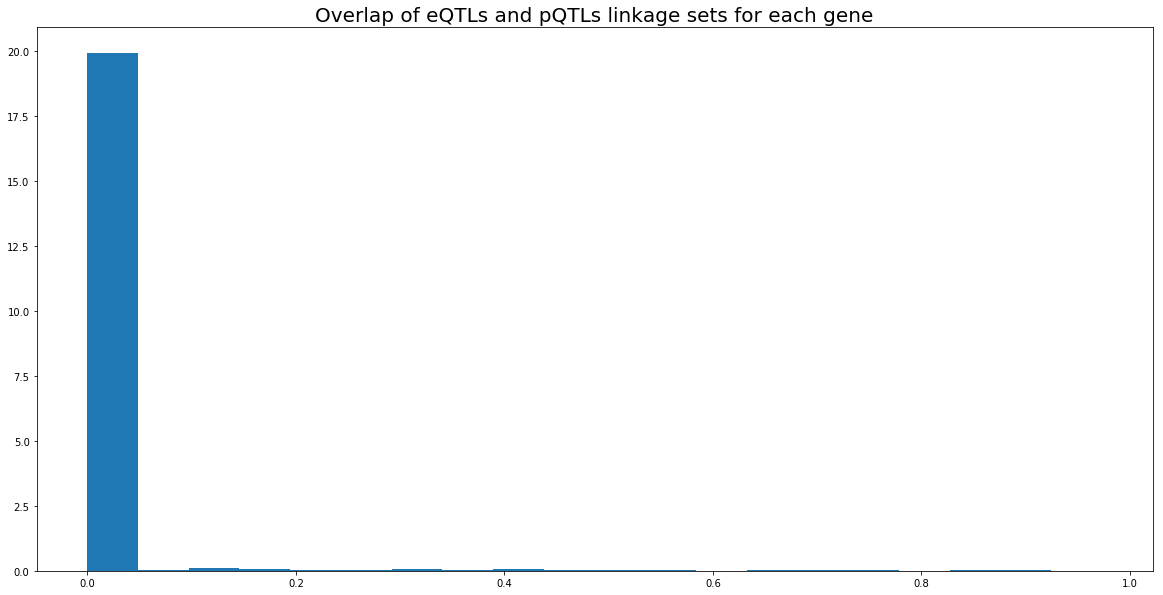

In [53]:
common_genes_with_linkages = np.unique(np.append(eQTLs_df["gene"].values, pQTLs_df["gene"].values))
linkage_overlap = []
for gene_name in common_genes_with_linkages:
    linked_eQTLs = set(eQTLs_df[eQTLs_df["gene"] == gene_name]["SNP"].values)
    linked_pQTLs = set(pQTLs_df[pQTLs_df["gene"] == gene_name]["SNP"].values)
    linkage_overlap.append(len(linked_eQTLs & linked_pQTLs) / len(linked_eQTLs | linked_pQTLs))
plt.figure(figsize=(20, 10))
plt.hist(linkage_overlap, bins=20, density=True);
plt.title("Overlap of eQTLs and pQTLs linkage sets for each gene", fontsize=20);

First, it can be shown that interacting genes tend to share linkages.  
To establish that the following procedure was used:   
- Generate 1000 FDR-cutoffs in range 1e-8...1e-2
- For each threshold:
	- Select subset of significant QTLs according to given threshold
	- Divide interactions into categories and extract corresponding subgraphs
	- Perform subgraph clusterization and calculate mean Jaccard coefficient between eQTL- and pQTL-linkage sets for each cluster. Average of those is taken to be mean linkage similarity measure. No sophisticated clustering is used at the moment: each edge forms its own cluster. Nevertheless, this proves to be sufficient to show statistically significant dependence.
	- In order to ensure that observed linkage similarity is not an artefact of interactions graph structure and not its biological meaning, those graphs are randomized preserving degree sequence and analyzed in the same manner. These experiments provide strong evidence for hypothesis being tested: mean linkage similarity becomes significantly smaller. 


In [70]:
# Given a list of gene-gene interactions of some kind (pairs of genes treated as edges),
# construct a graph and, if specified, randomize it, preserving some invariant (degree sequence or distribution etc)

def assemble_graph_of_interactions(edges, directed=False, randomize=False):
    interaction_graph = ig.Graph(directed=directed)
    # For some weird reason, igraph can add multiple copies of the same vertex.
    # Numpy can unpack a list of tuples into 1-D array and filter out duplicates
    vertex_names = np.unique(np.ravel(edges))
    interaction_graph.add_vertices(vertex_names)
    interaction_graph.add_edges(edges)

    if randomize:
        if directed:
            interaction_graph = interaction_graph.Degree_Sequence(
                interaction_graph.outdegree(),
                interaction_graph.indegree(),
                method='vl'
            )
        else:
            interaction_graph = interaction_graph.Degree_Sequence(
                interaction_graph.degree(),
                method='vl'
            )
            
    interaction_graph.vs["name"] = vertex_names
    
    # Due to domain-related specifics,
    # directed graphs produced by this function
    # will represent marker-gene interactions
    # and must be bipartite therefore
    if directed:
        interaction_graph.vs["part"] = np.array(interaction_graph.outdegree()) == 0
    
    return interaction_graph


''' TODO:   Стоит попробовать более совершенные метрики
            подобия, а также добиться лучшей скорости работы 
'''

# Given a pair of graphs, representing gene-gene interactions
# and estimated QTL-linkages, calculate for each pair of interacting genes
# a Jaccard similarity coefficient, and then average it over all edges
def mean_linkage_similarity(interaction_graph, QTL_graph):
    genes_with_linkages = QTL_graph.vs.select(part=1)["name"]
    genes_with_interactions = interaction_graph.vs["name"]

    # Как поступать с петлями? Их учитывать или нет?
    subgraph_with_linkages = interaction_graph.subgraph(
        set(genes_with_linkages) & set(genes_with_interactions)
    ).simplify() # remove loops and multiple edges


    if not subgraph_with_linkages.ecount():
        return 0 # такой граф нет смысла проверять

    # Перебрать все рёбра и сопоставить каждому пару множеств —
    # eQTLs, которые линкуются с концами ребра —
    # а затем подсчитать для них долю общих элементов

    mean_jaccard = 0.
    for edge in subgraph_with_linkages.es: # можно ли убрать этот цикл?
        source = subgraph_with_linkages.vs[edge.source]
        target = subgraph_with_linkages.vs[edge.target]
        
        s_neigh = set(QTL_graph.neighbors(source["name"], mode="IN"))
        t_neigh = set(QTL_graph.neighbors(target["name"], mode="IN"))
        mean_jaccard += len(s_neigh & t_neigh) / len(s_neigh | t_neigh)

    return mean_jaccard / subgraph_with_linkages.ecount()



In [16]:
def analyze_interactions(QTL_df, Q_RANGE, REWIRE_FLAG=False):
    avg_similarity_by_category = {}
    # TODO: how to add more subcategories?
    for name in ['genetic', 'physical'] + interaction_categories:
        avg_similarity_by_category[name] = []
        
    interaction_graphs_dict = {}
    for category_name in interaction_categories:
        interacting_genes_df = interactome_df[interactome_df.index == category_name]
        interaction_graphs_dict[category_name] = assemble_graph_of_interactions(
            interacting_genes_df[["Interactor A", "Interactor B"]].values,
            randomize=REWIRE_FLAG
        )
    # TODO: Remove code duplication
    genetic_interactions_graph = assemble_graph_of_interactions(
        edges=genetic_interactions_df[["Interactor A", "Interactor B"]].values,
        randomize=REWIRE_FLAG
    )
    physical_interactions_graph = networks.assemble_graph_of_interactions(
        edges=physical_interactions_df[["Interactor A", "Interactor B"]].values,
        randomize=REWIRE_FLAG
    )

    for Q_THRESHOLD in Q_RANGE[::-1]:
        QTL_df = QTL_df[QTL_df['q.value'] <= Q_THRESHOLD]
        QTL_graph = assemble_graph_of_interactions (
            edges=QTL_df[["SNP", "gene"]].values,
            directed=True
        )
        avg_similarity_by_category['genetic'].append(
            mean_linkage_similarity(genetic_interactions_graph, QTL_graph)
        )
        avg_similarity_by_category['physical'].append(
            mean_linkage_similarity(physical_interactions_graph, QTL_graph)
        )
        for category_name, interaction_graph in interaction_graphs_dict.items():
            avg_similarity_by_category[category_name].append(
                mean_linkage_similarity(interaction_graph, QTL_graph)
            )
            
    return avg_similarity_by_category


In [17]:
def plot_calculated_linkage_similarity(avg_sim_by_category, avg_sim_by_category_randomized, type_of_QTLs, Q_RANGE):
   for name in avg_sim_by_category.keys():
        plt.figure(figsize=(20, 10))
        plt.xscale('log')
        plt.plot(Q_RANGE, avg_sim_by_category[name][::-1], label="original")
        plt.plot(Q_RANGE, avg_sim_by_category_randomized[name][::-1], label="randomized")
        plt.title('{} average linkage similarity'.format(type_of_QTLs))
        plt.xlabel(name)
        plt.legend()
        plt.savefig("./img/interactions/" + type_of_QTLs + '_' + name + ".png")
        plt.close()

In [445]:
Q_RANGE = np.linspace(1e-8, 1e-2, 1000)

t0 = time.time()
pool = mp.Pool(processes=4)
results = pool.starmap(
            analyze_interactions, 
            [(eQTLs_df, Q_RANGE, False),
             (eQTLs_df, Q_RANGE, True),
             (pQTLs_df, Q_RANGE, False),
             (pQTLs_df, Q_RANGE, True)]
        )  
pool.close()
pool.join()

print(time.time() - t0)

298.3739845752716


In [447]:
plot_calculated_linkage_similarity(results[0], results[1], 'eQTLs', Q_RANGE)
plot_calculated_linkage_similarity(results[2], results[3], 'pQTLs', Q_RANGE)

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), there will be a strong evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results). This approach can also be used to predict pQTLs, as protein expression data is noisy and is obtained through expensive experiments. It also greatly (orders of magnitude) reduces computational complexity, as naive approach testing all (marker, gene) pairs must perform ~15m statistical tests (MWU) and is unfeasible for larger genomes (especially human ones): taking interactions into consideration allows one to filter out pairs that are unlikely to link.

In [14]:
def convert_to_std(gene_name):
    try:
        result = sys_to_std[gene_name]
    except KeyError:
        result = gene_name
    return result


def convert_to_sys(gene_name):
    try:
        result = std_to_sys[gene_name]
    except KeyError:
        result = gene_name
    return result

def get_interacting_genes(gene_name, interactions_graph, bfs_depth=1):
    try: 
        return set(interactions_graph.vs[
                       interactions_graph.neighborhood(gene_name, order=bfs_depth)
                   ]["name"])
    except ValueError:
        return set()

    
def get_linked_markers(gene_name, QTL_df):
    return set(QTL_df[QTL_df["gene"] == gene_name]["SNP"].values)

def get_linked_genes(marker_name, QTL_df):
    return set(QTL_df[QTL_df["SNP"] == marker_name]["gene"].values)


def get_linked_to_adjacent(gene_name): 
    interacting_genes = set(gene_name) \
                        | get_interacting_genes(gene_name, physical_interactions_graph) \
                        | get_interacting_genes(gene_name, genetic_interactions_graph)
    linked = set()
    for neighbor in interacting_genes:
        linked |= get_linked_markers(neighbor, eQTLs_df) 
        if neighbor != gene_name:
            linked |= set(neighbor)
    return linked 
        


In [7]:
valid_markers = set(pQTLs_genotypes_df["SNP"].values)
valid_genes = set(pQTLs_expression_df["gene"].values)

# https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
''' Optimize using np.meshgrid! '''
def get_possible_linkages(gene_name):
    linked = get_linked_to_adjacent(gene_name)
    interacting = set(gene_name) \
                | get_interacting_genes(gene_name, physical_interactions_graph) \
                | get_interacting_genes(gene_name, genetic_interactions_graph)
    return [(marker, gene_name) for marker in (linked | interacting) & valid_markers]

pool = mp.Pool(8)
results = pool.map(get_possible_linkages, pQTLs_expression_df["gene"].values)
possible_linkages = list(set(sum(results, []))) # --> np.unique
pool.close()
pool.join()

In [8]:
def calculate_p_value(candidate_linkage):
    marker_name, gene_name = candidate_linkage
    genotype_rowmask = pQTLs_genotypes_df["SNP"] == marker_name
    genotype_row = pQTLs_genotypes_mx[genotype_rowmask]
    expression_rowmask = pQTLs_expression_df["gene"] == gene_name
    expression_row = pQTLs_expression_mx[expression_rowmask]
    from_BY = expression_row[genotype_row == 0]
    from_RM = expression_row[genotype_row == 2]
    _, p_value = stats.mannwhitneyu(from_BY, from_RM, alternative="two-sided")
    return p_value

pool = mp.Pool(8)
p_values = pool.map(calculate_p_value, possible_linkages)
pool.close()
pool.join()

pd.DataFrame(p_values, columns=["pvalue"]).to_csv("./data/pQTLs/pvalues.csv", sep='\t', index=False)
subprocess.check_call(['Rscript', './src/p-values_to_q-values.R'], shell=False)
q_values = pd.read_table("./data/pQTLs/qvalues.csv").values
reject = q_values <= 0.05

new_pQTLs_list = []

for i in range(len(possible_linkages)):
    marker_name, gene_name = possible_linkages[i]
    new_pQTLs_list.append((marker_name, gene_name, p_values[i], q_values[i], reject[i]))

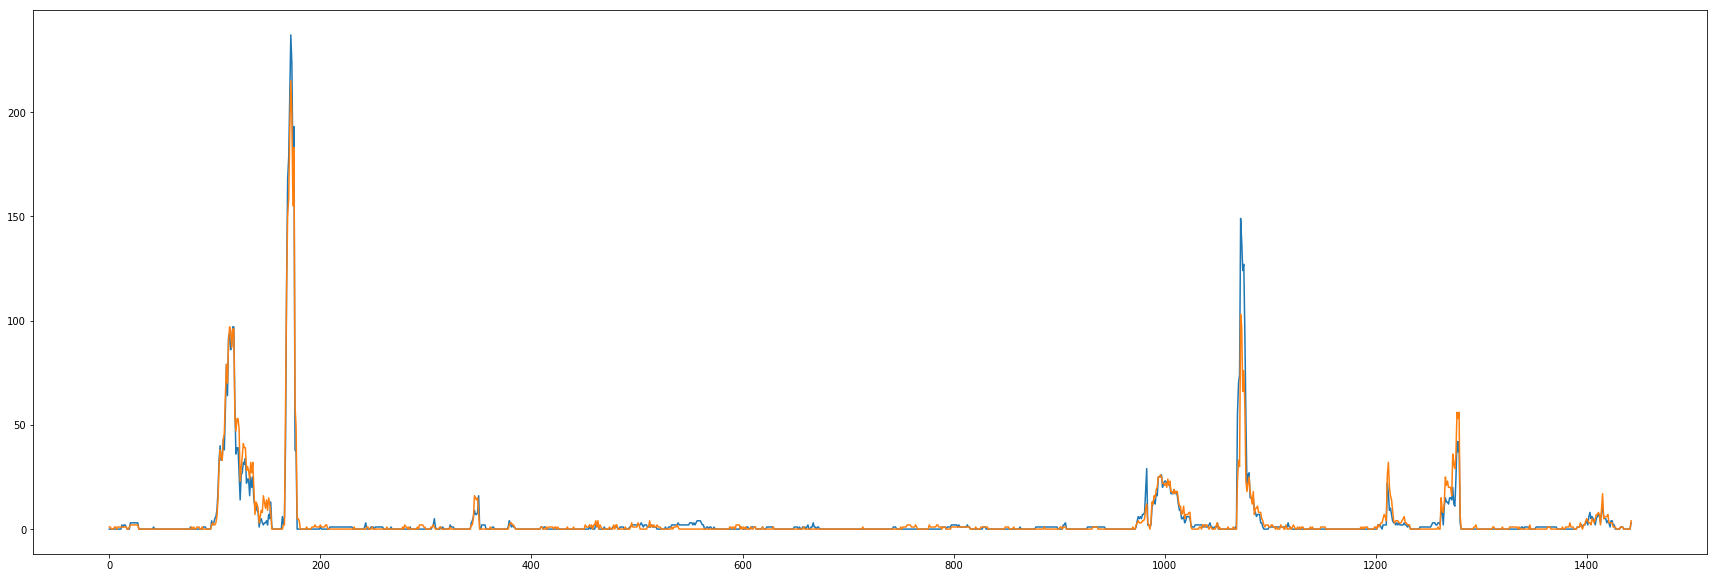

In [11]:
# Original and new results comparison via plots
new_pQTLs_df = pd.DataFrame(new_pQTLs_list, columns=["SNP", "gene", "pvalue", "qvalue", "reject"])
new_pQTLs_df = new_pQTLs_df[new_pQTLs_df["reject"] == True] 
new_pQTLs_df.to_csv("./data/pQTLs/new_results.csv", sep='\t', index=False, na_rep='NA')

old_pQTL_x, old_pQTL_y = qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)
new_pQTL_x, new_pQTL_y = qtls.map_linkages_to_genome_location(new_pQTLs_df, full_genotypes_df)

plt.figure(figsize=(30, 10))
# plt.xticks(range(len(old_pQTL_x)), [s if old_pQTL_y[i] > 300 else "" for i, s in enumerate(old_pQTL_x)], rotation='vertical', size=4)
plt.plot(old_pQTL_y, label="pQTLs found by brute force")
plt.plot(new_pQTL_y, label="pQTLs predicted from interactions")
plt.legend()
# plt.plot([-y for y in eQTL_y])
plt.savefig("./img/linkages/pQTLs_old_and_new.png", format="png", dpi=300) 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Physical and genetic interactions**:  
-  Common linkages: 3695, 59.96429730606946%
- Old linkages, total: 6162
- New linkages, total: 6124
- New linkages found: 2429

In [ ]:
new_pQTLs_df = pd.read_table("./data/pQTLs/new_results.csv", sep='\t')
new_pQTLs_df = new_pQTLs_df[new_pQTLs_df["reject"] == "[ True]"] 

# approach quality evaluation:
num_linked_to_gene = { gene_name: 0 for gene_name in pQTLs_df["gene"].values }
num_linked_to_marker = { marker_name: 0 for marker_name in pQTLs_df["SNP"].values }
for marker_name, gene_name in pQTLs_df[["SNP", "gene"]].values:
    num_linked_to_marker[marker_name] += 1
    num_linked_to_gene[gene_name] += 1

old_pQTL_linkage_pairs = set(
    (marker_name, gene_name) 
    for marker_name, gene_name in pQTLs_df[["SNP", "gene"]].values
)

common = 0
for marker_name, gene_name in new_pQTLs_df[["SNP", "gene"]].values:
    linkage_pair = (marker_name, gene_name)
    common += linkage_pair in old_pQTL_linkage_pairs
    
print(
    "Common linkages: {}, {}%\n"
    "Old linkages, total: {}\n"
    "New linkages, total: {}\n"
    "New linkages found: {}"
    .format(common, 100 * common / pQTLs_df.shape[0], 
            pQTLs_df.shape[0], 
            new_pQTLs_df.shape[0], 
            new_pQTLs_df.shape[0] - common)
)


ZeroDivisionError: division by zero

Nevertheless, obtained results make little sense without biological interpretation. In order to illustrate the hypothesis on some real-world data, curated functional modules are tested.

In [96]:
functional_modules = {}
for module_type in functional_modules_types:
    functional_modules[module_type] = functional_modules_df[
        functional_modules_df["Function"].str.contains(module_type)
    ]["Interactor (std)"].values

physical_interactions_graph = assemble_graph_of_interactions(physical_interactions_df[["Interactor A", "Interactor B"]].values)
genetic_interactions_graph = assemble_graph_of_interactions(genetic_interactions_df[["Interactor A", "Interactor B"]].values,)
eQTLs_graph = assemble_graph_of_interactions (edges=eQTLs_df[eQTLs_df["q.value"] <= 0.05][["SNP", "gene"]].values, directed=True)
pQTLs_graph = assemble_graph_of_interactions (edges=pQTLs_df[pQTLs_df["q.value"] <= 0.05][["SNP", "gene"]].values, directed=True)

def analyze_functional_modules(functional_modules, interactions_graph, interactions_type, rewire=False):
    results_log = ""
    for module_type in functional_modules.keys(): 
        module_graph = interactions_graph.subgraph(
            set(functional_modules[module_type]) 
            & set(interactions_graph.vs["name"]),
        ).simplify()
        
        # module_graph.vs.select(_degree=0).delete()
        
        if rewire:
           for _ in range(100):
                vertex_names = module_graph.vs["name"]
                module_graph = module_graph.Degree_Sequence(
                    module_graph.degree(),
                    method='simple'
                )
                module_graph.vs["name"] = vertex_names
        
        # ig.plot(module_graph, target="./img/functional_modules/" 
        #                                 + ("randomized/" if rewire else "raw/") 
        #                                 +  "module_graph_" + module_type.replace('/', "_") + ".png");
        
        results_log += "{}:\n".format(module_type) \
                        + "\t- num_vertices\t{}\n".format(module_graph.vcount()) \
                        + "\t- num_edges\t{}\n".format(module_graph.ecount()) \
                        + "\t- eQTLs sim.\t{}\n".format(round(mean_linkage_similarity(module_graph, eQTLs_graph), 3)) \
                        + "\t- pQTLs sim.\t{}\n".format(round(mean_linkage_similarity(module_graph, pQTLs_graph), 3))
        
    functional_modules_file = open("./data/interactions/"
                                    + interactions_type + "_"  
                                    + ("randomized" if rewire == True else "raw") 
                                    + "_module_graph_linkage_similarity_statistics.txt", "w")
    functional_modules_file.write(results_log)

analyze_functional_modules(functional_modules, physical_interactions_graph, "physical_interactions")
analyze_functional_modules(functional_modules, physical_interactions_graph, "physical_interactions", True)
analyze_functional_modules(functional_modules, genetic_interactions_graph, "genetic_interactions",)
analyze_functional_modules(functional_modules, genetic_interactions_graph, "genetic_interactions", True)